# Movie critics - sentiment-analysis - solution

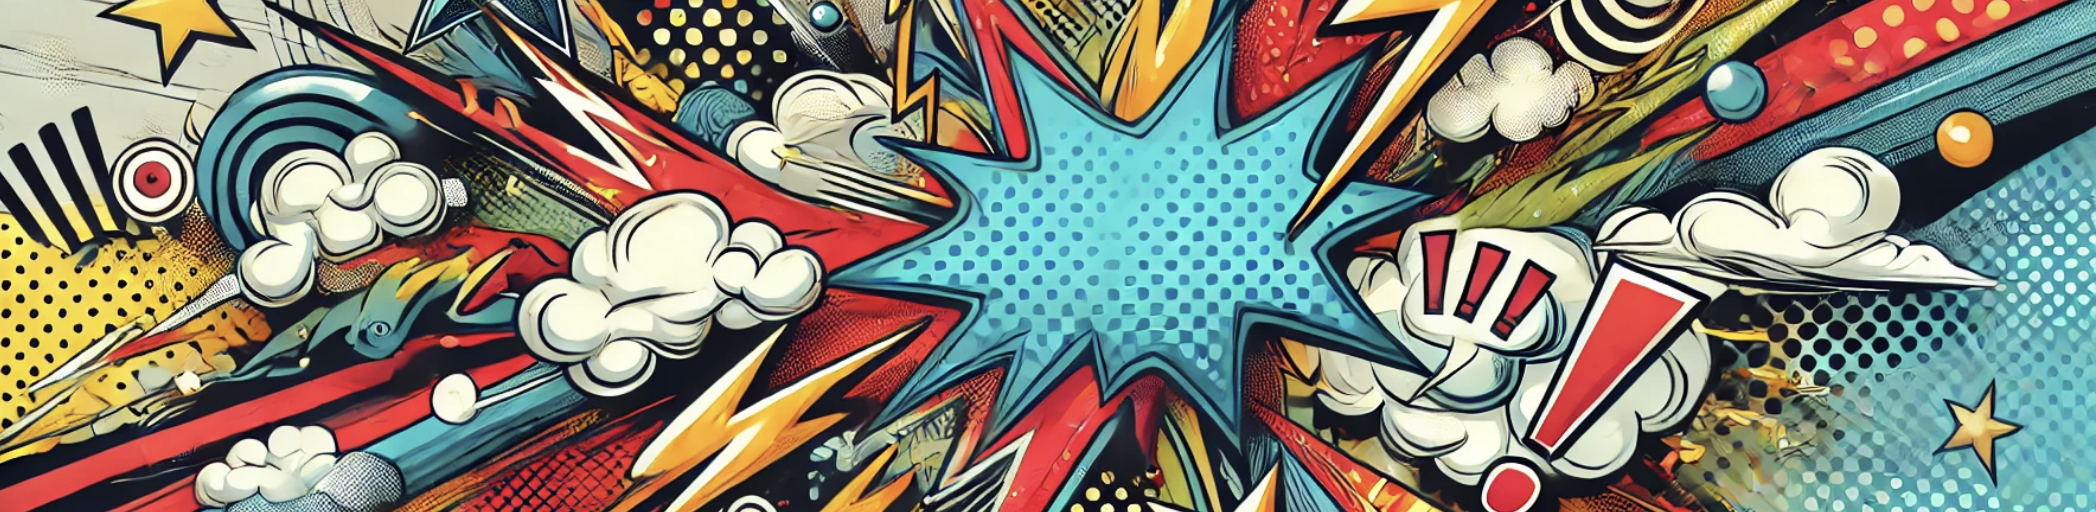

Note: ```%%capture``` "cell magic" captures messages sent to ```stdout/stderr``` (Unix outputs) by a cell, i.e. errors or steps in the installation process. Without parameter, you can discard these streams with the magic or store them in a variable by specifying a variable name [e.g. allcontent].

First, install the [YouTube subtitle download API](https://pypi.org/project/youtube-transcript-api/). It basically looks for English subtitles and only works on videos that have subtitles (even if they are automatically generated).

In [ ]:
%%capture
pip install youtube-transcript-api

The created `get_transcript()` function retrieves the transcript of the video specified as the `video_id` parameter using the API.

We get the video subtitles by combining them in a list: combined_text.

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_transcript(video_id):
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    combined_text = " ".join([entry['text'] for entry in transcript])
    return combined_text

A videó lista (List):

In [ ]:
video_ids = [
    "JTyZeMPOP18",
    "z0Ntsk-i4ks",
    "hjesFmiKOOY",
    "5H2s7nkDugo",
    "IjGLRKhDDnA",
    "l_n-Cw_whls",
    "DLquU1VZkBA",
    "myKMOgTzins",
]

A [list comprehension](https://docs.python.org/2/tutorial/datastructures.html) creates a list from the input list.

In [ ]:
combined_texts = [get_transcript(video_id) for video_id in video_ids]

It's not mandatory, just to know what the API has downloaded, we'll print the first 100 characters of all 8 video transcript texts:

In [ ]:
for i in range(len(combined_texts)): # elemek ciklusbeli végiglépegetése
   print(i, combined_texts[i][0:100])

0 Deadpool - once again stars Ryan Reynolds as Wade Wilson the Merc with the mouth whoo this time arou
1 [Music] Deadpool - yeah I couldn't even think of anything to say for the intro for a Deadpool to rev
2 [Applause] [Music] [Applause] [Music] there's a scene about halfway through Deadpool - that I think 
3 Deadpool was a surprise hit breaking box-office records for an r-rated movie but more importantly is
4 so Deadpool 2 if you will remember cast your mind back to my review of Deadpool when it came out thi
5 [Music] after Deadpool one came out of nowhere and made everyone lose their minds a sequel will rise
6 here we are with actual actors a moderate special effects budget and several low-level x-men none of
7 welcome back to new rock stars I'm Eric Boss and this is a breakdown of 2018s Deadpool 2 this is the


Note: Runs in 8s on Google Colab CPU and for the same amount of time on T4 TPU. The speedup is not noticeable here, but see below.

## Tokenizer and Pipeline
### Tokenizer
**Task**: The `tokenizer` is responsible for converting raw text into a numeric format that can be understood by the `sentiment-analysis` model.

* Splitting the text into tokens (words, subwords, or characters).
* Converting the tokens into numeric identifiers based on the `tokenizer` 'vocabulary'.
* Adding special tokens (e.g. `[CLS]`, `[SEP]` for classification tasks).
* Padding or truncating strings to a fixed length.

We use `DistilBertTokenizer` because the selected IMDb-based sentiment-analyzer also uses this method.

### Pipeline

**Task**: The pipeline is a high-level abstraction provided by `HuggingFace` to perform common `NLP` tasks (e.g. sentiment analysis, text generation, translation). In this case:

* The `pipeline` is set up for sentiment analysis.
* It uses the pre-trained `lvwerra/distillert-imdb` ​​model, which is specifically trained using the IMDb dataset, to classify the given text as positive, neutral or negative.

**How ​​it works**:

* The input text is tokenized using the associated `tokenizer`.
* The tokenized input data is passed through the model.
* The output (logits) of the model are processed to generate a sentiment label (POSITIVE, NEUTRAL or NEGATIVE) along with a confidence score. The scores are not used here.

[HuggingFace](https://huggingface.co/)

[Tokenizer more (ENG)](https://huggingface.co/docs/transformers/main_classes/tokenizer)

In [ ]:
from transformers import pipeline, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('lvwerra/distilbert-imdb')
sentiment_pipeline = pipeline('sentiment-analysis', model="lvwerra/distilbert-imdb")

Device set to use cuda:0


To analyze longer texts, we cut the text into 500-character segments (considering negligible the distorting effect of the words that may have been cut) and summarize the results of each segment in the positive/negative/neutral "containers", i.e. we get an overall picture. The answer with the highest (total) score (+/-/0) is given as the output.

In [ ]:
def split_text_into_chunks(text, max_length=500):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_length):
        chunk = tokens[i:i + max_length]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text)
    return chunks

def analyze_sentiment_for_long_text(long_text):
    chunks = split_text_into_chunks(long_text)
    positive_score, negative_score, neutral_score = 0.0, 0.0, 0.0

    for chunk in chunks:
        result = sentiment_pipeline(chunk)
        for res in result:
            if res['label'] == 'POSITIVE':
                positive_score += res['score']
            elif res['label'] == 'NEGATIVE':
                negative_score += res['score']
            elif res['label'] == 'NEUTRAL':
                neutral_score += res['score']

    if positive_score > negative_score and positive_score > neutral_score:
        return 'POSITIVE'
    elif negative_score > positive_score and negative_score > neutral_score:
        return 'NEGATIVE'
    else:
        return 'MIXED/NEUTRAL'

Sentiment analysis on list elements:



In [ ]:
review_sentiments = []

for text in combined_texts:
    sentiment = analyze_sentiment_for_long_text(text)
    review_sentiments.append(sentiment)

#printing of resulst of elements, in cycle
for idx, sentiment in enumerate(review_sentiments):
    print(f"Review {idx+1}: {sentiment}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Review 1: POSITIVE
Review 2: POSITIVE
Review 3: POSITIVE
Review 4: POSITIVE
Review 5: NEGATIVE
Review 6: NEGATIVE
Review 7: POSITIVE
Review 8: POSITIVE


Note: 29s with Colab CPU and 2s using Colab T4 TPU. This is an effective speedup on T4 TPU!

In [ ]:
pip freeze > movie_reviews_requirements.txt

## Additional info - titles
Download YouTube video titles (API).

A personal [Google Cloud API key](https://cloud.google.com/docs/authentication/api-keys-use) is required, which must be entered as DEVELOPER_KEY.

Other details can be downloaded, but here we are only interested in the title.

In [ ]:
pip install googleapiclient #install API modul

In [ ]:
import pprint #formatted printing
import googleapiclient.discovery as gacd # API

In [ ]:
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "YOUR_API_KEY" #"YOUR_API_KEY" should be changed to your API key e.g. "78k945..."

youtube = gacd.build(api_service_name, api_version, developerKey = DEVELOPER_KEY)

In [ ]:
def get_yt_video_title(video_id):
  # the general youtube video link format: https://www.youtube.com/watch?v=VIDEO_ID
  request = youtube.videos().list(
    part='snippet',
    id=video_id
    )
  response = request.execute() #query
  return response['items'][0]['snippet']['title'] # return the title

Let's query the video titles with the created function (in a loop, formatted with pretty print).

In [ ]:
for video_id in video_ids:
  pprint.pprint(get_yt_video_title(video_id))

```
Deadpool 2 - Movie Review
Deadpool 2 - Movie Review
Is Deadpool 2 Obnoxious Or Genius?
Deadpool 2 Review
Deadpool 2 reviewed by Mark Kermode
Honest Trailers - Deadpool 2 (Feat. Deadpool)
Deadpool 2 Review and Ending Explained
DEADPOOL 2 (2018) BREAKDOWN! Easter Eggs & Details You Missed! | X-Men Rewatch
```

So, is Deadpool 2 ultimately a positive review? What do you think? :)